Import everything you need so as to setup the environment.

In [1]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
import glob
import time
import pickle
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML

from scipy.ndimage.measurements import label
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

%matplotlib inline

Using a bunch of functions from the lessons. These are the functions used to extract features out of the test images

In [2]:
def color_transform(img, color_space):
    if color_space != 'RGB':
        if color_space == 'HSV':
            output_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            output_img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            output_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            output_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            output_img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        elif color_space == 'RGB2YCrCb':
            output_img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        elif color_space == 'BGR2YCrCb':
            output_img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        elif color_space == 'RGB2LUV':
            output_img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    else: output_img = np.copy(img)   
    return output_img

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

def color_hist(img, nbins=32):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins)
    ghist = np.histogram(img[:,:,1], bins=nbins)
    bhist = np.histogram(img[:,:,2], bins=nbins)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features, rhist, ghist, bhist, bin_centers

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Extract features for an image; Note input is an image file
def extract_features_single(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    feature_image = color_transform(img, color_space)
       
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features, _, _, _, _ = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
            hog_features = np.concatenate(hog_features)           
        else:
            if vis==True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    
    #9) Return concatenated array of features
    if vis==True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

#Extract features for a bunch of images five a file path
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        image = mpimg.imread(file)
        file_features = extract_features_single(image, color_space, spatial_size, hist_bins, orient, pix_per_cell,
                                           cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)
        
        features.append(file_features)
    # Return list of feature vectors
    return features


# Draw boxes on an image given the bboxes co-ordinates            
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

Number of cars: 8792
Number of non-cars: 8968


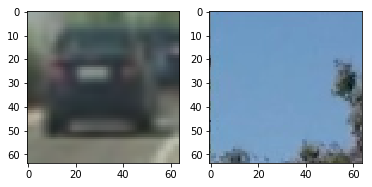

In [4]:
# Read in cars and notcars from the udacity data set provided. This can take very long
# and hence I restrict the number of images. Accuracy seems to vary
# depending on the images used.
cars = []
noncars = []

# populate cars
image_types = os.listdir("vehicles/")
for imtype in image_types:
    cars.extend(glob.glob("vehicles/" + imtype + '/*'))

# populate non-cars
image_types = os.listdir("non-vehicles/")
for imtype in image_types:
    noncars.extend(glob.glob("non-vehicles/" + imtype + '/*'))
    
print('Number of cars:', len(cars))
print('Number of non-cars:', len(noncars))

#Make sure there are images in array
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(mpimg.imread(cars[0]))
fig.add_subplot(1,2,2)
plt.imshow(mpimg.imread(noncars[0]));

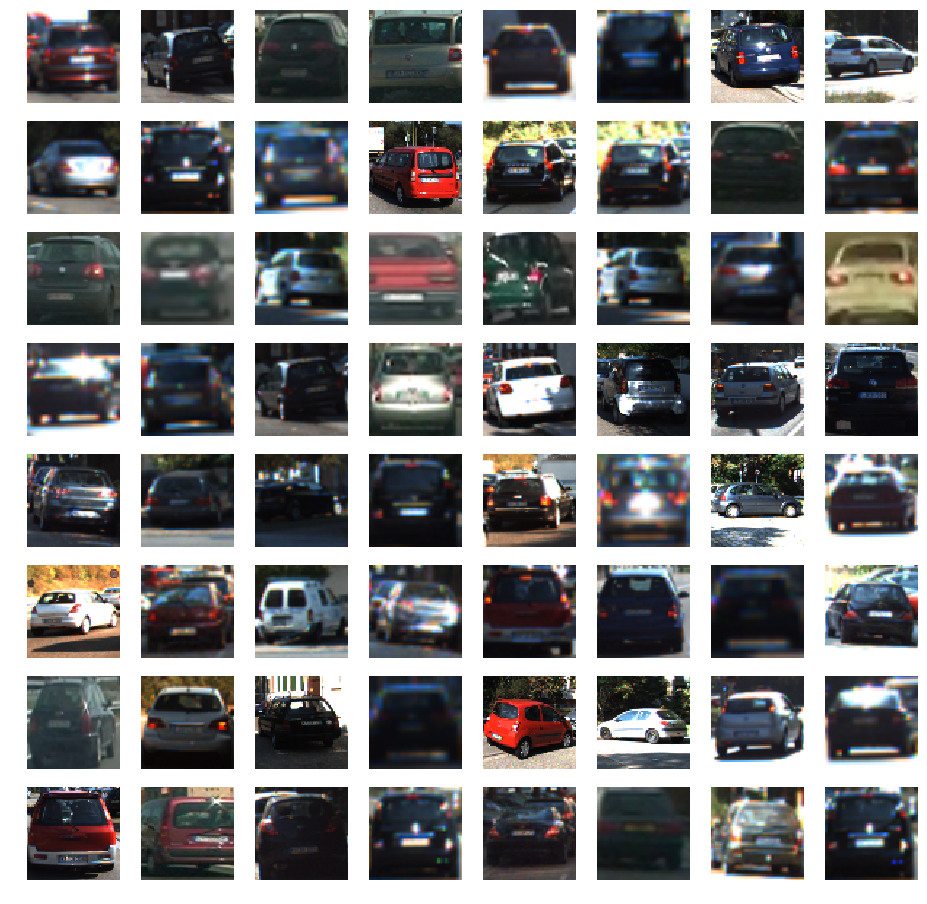

In [5]:
#Plot some car images
fig=plt.figure(figsize=(16,16))

for i in range(0,64):
    ax = fig.add_subplot(8,8,i+1)
    idx = np.random.randint(len(cars));
    plt.imshow(mpimg.imread(cars[idx]));
    plt.axis('off')

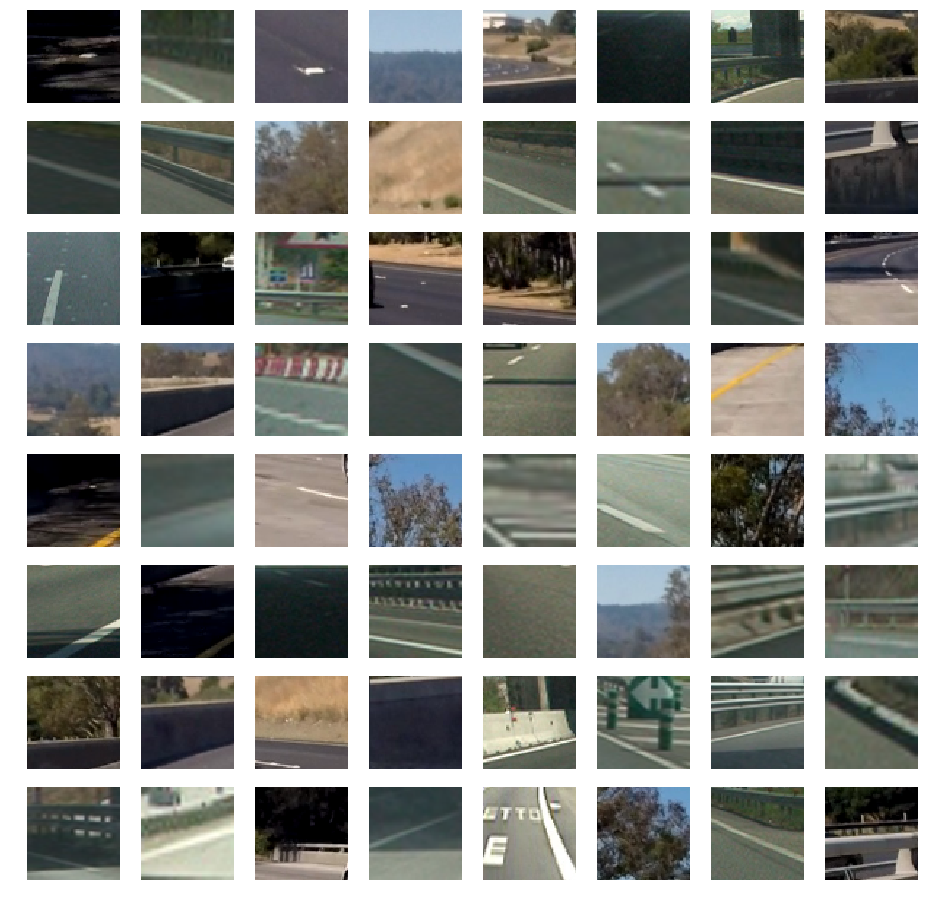

In [6]:
#Plot some non-car images
fig=plt.figure(figsize=(16,16))

for i in range(0,64):
    ax = fig.add_subplot(8,8,i+1)
    idx = np.random.randint(len(noncars));
    plt.imshow(mpimg.imread(noncars[idx]));
    plt.axis('off')

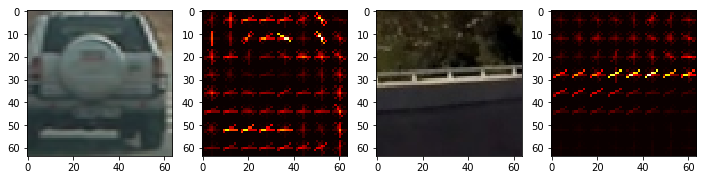

In [7]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 6  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


car_idx = np.random.randint(0, len(cars))
non_car_idx = np.random.randint(0, len(noncars))

car_img = mpimg.imread(cars[car_idx])
non_car_img = mpimg.imread(noncars[non_car_idx])

f, car_hog_image = extract_features_single(car_img, color_space=color_space, spatial_size=spatial_size,
                                           hist_bins=hist_bins, orient=orient,
                                           pix_per_cell=pix_per_cell, 
                                           cell_per_block=cell_per_block, hog_channel=hog_channel,
                                           spatial_feat=spatial_feat, 
                                           hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

f, non_car_hog_image = extract_features_single(non_car_img, color_space=color_space, 
                                               spatial_size=spatial_size,
                                               hist_bins=hist_bins, orient=orient,
                                               pix_per_cell=pix_per_cell, 
                                               cell_per_block=cell_per_block, 
                                               hog_channel=hog_channel,
                                               spatial_feat=spatial_feat, 
                                               hist_feat=hist_feat, hog_feat=hog_feat, vis=True)


fig = plt.figure(figsize=(12,3))

plt.subplot(1, 4, 1)
plt.imshow(car_img)

plt.subplot(1, 4, 2)
plt.imshow(car_hog_image, cmap='hot')

plt.subplot(1, 4, 3)
plt.imshow(non_car_img)

plt.subplot(1, 4, 4)
plt.imshow(non_car_hog_image, cmap='hot');


Final set of parameters after experimenting with several different values

In [8]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, 'ALL'
spatial_size = (16, 16) # down sample size
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

car_features = extract_features(cars, color_space=color_space, spatial_size=spatial_size,
                                hist_bins=hist_bins, orient=orient,
                                pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, hog_channel=hog_channel,
                                spatial_feat=spatial_feat, hist_feat=hist_feat, 
                                hog_feat=hog_feat)


non_car_features = extract_features(noncars, color_space=color_space, 
                                    spatial_size=spatial_size,
                                    hist_bins=hist_bins, orient=orient,
                                    pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, hog_channel=hog_channel,
                                    spatial_feat=spatial_feat, 
                                    hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, non_car_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
%time svc.fit(X_train, y_train)
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6156
CPU times: user 17.6 s, sys: 977 ms, total: 18.6 s
Wall time: 20.4 s
Test Accuracy of SVC =  0.9901


In [9]:
# Define a function that takes an image, start and stop positions in both x and y, 
# window size (x and y dimensions), and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [10]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB',
                   spatial_size=(32, 32), hist_bins=32,
                   hist_range=(0, 256), orient=9,
                   pix_per_cell=8, cell_per_block=2,
                   hog_channel=0, spatial_feat=True,
                   hist_feat=True, hog_feat=True):
    on_windows = []
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], 
                                  window[0][0]:window[1][0]], (64, 64))      
        # Extract features for test image
        features = extract_features_single(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(test_features)

        if prediction == 1:
            on_windows.append(window)
    
    return on_windows

In [11]:
# TODO: Experiment with different overlap values and window size
def process_image(img, y_start_stop=[None, None], xy_window=(128, 128), overlap=.5):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    print(np.min(img), np.max(img))

    windows = slide_window(img, x_start_stop=[None, None], 
                           y_start_stop=y_start_stop,
                           xy_window=xy_window, xy_overlap=(overlap, overlap))
    
    t1 = time.time()

    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space,
                                 spatial_size=spatial_size, hist_bins=hist_bins,
                                 orient=orient, pix_per_cell=pix_per_cell, 
                                 cell_per_block=cell_per_block,
                                 hog_channel=hog_channel, spatial_feat=spatial_feat,
                                 hist_feat=hist_feat, hog_feat=hog_feat)
    
    print(time.time()-t1, 'seconds to process a large image with', len(windows), 'windows')
    
    window_img = draw_boxes(draw_img, hot_windows, color=(0,0,255), thick=6)
    return window_img

0.0 1.0
0.6843430995941162 seconds to process a large image with 180 windows
0.0 1.0
0.6657819747924805 seconds to process a large image with 180 windows
0.0 1.0
0.6662609577178955 seconds to process a large image with 180 windows
0.0 1.0
0.6651537418365479 seconds to process a large image with 180 windows
0.0 1.0
0.6491332054138184 seconds to process a large image with 180 windows
0.0 1.0
0.6589970588684082 seconds to process a large image with 180 windows


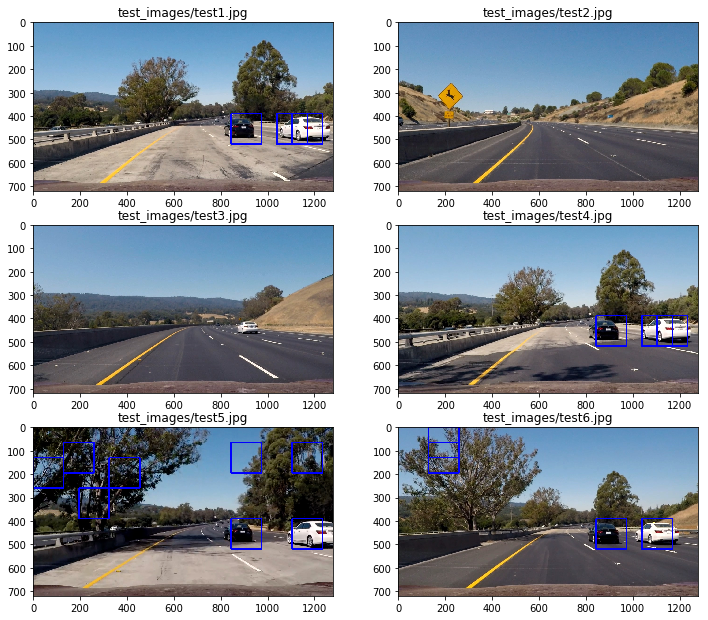

In [17]:
# attempt to draw windows on test_images
searchpath = 'test_images/*'
test_images = glob.glob(searchpath)

y_start_stop=[None, None]
xy_window=(130, 130)
overlap=.5

fig = plt.figure(figsize=(12,18))
idx=1
for filename in test_images:
    img = mpimg.imread(filename)
    window_img = process_image(img, y_start_stop, xy_window, overlap)
    
    plt.subplot(5, 2, idx)
    plt.imshow(window_img)
    plt.title(filename)
    idx+=1



These values seem to detect most cars. Unable to detact the car in test3 no matter how much I have tuned the parameters

0.0 1.0
0.30021095275878906 seconds to process a large image with 57 windows
0.0 1.0
0.21644020080566406 seconds to process a large image with 57 windows
0.0 1.0
0.22079181671142578 seconds to process a large image with 57 windows
0.0 1.0
0.21938085556030273 seconds to process a large image with 57 windows
0.0 1.0
0.21216297149658203 seconds to process a large image with 57 windows
0.0 1.0
0.24054598808288574 seconds to process a large image with 57 windows


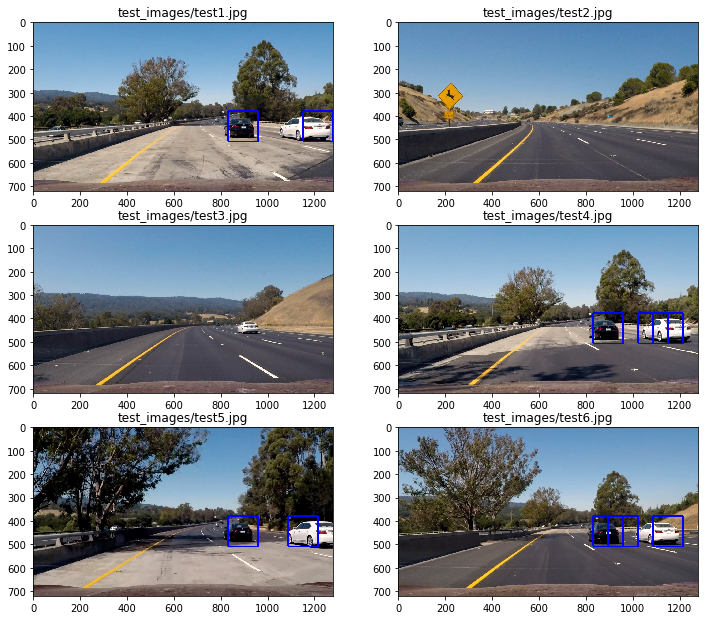

In [22]:
searchpath = 'test_images/*'
test_images = glob.glob(searchpath)

y_start_stop=[380,650]
xy_window=(128, 128)
overlap=.5

fig = plt.figure(figsize=(12,18))
idx=1
for filename in test_images:
    img = mpimg.imread(filename)
    window_img = process_image(img, y_start_stop, xy_window, overlap)
    
    plt.subplot(5, 2, idx)
    plt.imshow(window_img)
    plt.title(filename)
    idx+=1


In [29]:
from scipy.ndimage.measurements import label
def get_labels(heatmap):
    return label(heatmap)

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# a function that adds "heat" to a map for a list of bounding boxes
def generate_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
def find_cars(img, y_start_stops, x_start_stops, scales, cells_per_steps=[2], pix_per_cell=8, orient=9):
    img_boxes = []
    heatmap = np.zeros_like(img[:,:,0])
    
    # normalize
    img = img.astype(np.float32)/255
    
    window_count = 0
    t = time.time()
    
    for y_start_stop, x_start_stop, scale, cells_per_step in zip(y_start_stops, x_start_stops, scales, cells_per_steps):
    
        # crop to boundaries passed in
        cropped_img = img[y_start_stop[0]:y_start_stop[1],x_start_stop[0]:x_start_stop[1],:]
        # convert to new color
        cropped_img = color_transform(cropped_img, color_space='RGB2YCrCb')
        
        if scale != 1:
            imshape = cropped_img.shape
            resized_img = cv2.resize(cropped_img, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        else:
            resized_img = cropped_img

        ch1 = resized_img[:,:,0]
        ch2 = resized_img[:,:,1]
        ch3 = resized_img[:,:,2]

        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        nxblocks = (ch1.shape[1] // pix_per_cell) - 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - 1
        nfeat_per_block = orient*cell_per_block**2

        window=64
        nblocks_per_window = (window // pix_per_cell) - 1

        # cells_per_step defines overlap. 1 - cells_per_step / pix_per_cell gives us overlap percentage
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        for xb in range(nxsteps):
            for yb in range(nysteps):
                window_count += 1
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step

                # extract HOG for patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # extract the image patch for spatial and hist
                subimg = cv2.resize(resized_img[ytop:ytop+window, xleft:xleft+window], (64,64))

                # use spatial and color hist features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features, _, _, _, _ = color_hist(subimg, nbins=hist_bins)

                # stack all 3 features
                feature_stack = np.hstack((spatial_features, hist_features, hog_features))
                
                test_features = X_scaler.transform(feature_stack.reshape(1, -1))
                
                # prediction with SVM
                pred = svc.predict(test_features)

                if pred == 1:
                    xbox_left = np.int(xleft*scale) + x_start_stop[0]
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)

                    top_left = (xbox_left, ytop_draw+y_start_stop[0])
                    bottom_right = (xbox_left+win_draw, ytop_draw+win_draw+y_start_stop[0])

                    img_boxes.append((top_left, bottom_right))

    generate_heat(heatmap, img_boxes)
        
    return heatmap


def pipeline(image):
    out_img, windows = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, 
                             pix_per_cell, cell_per_block, spatial_size, hist_bins)

    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,windows)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

In [30]:
# Apply threshold to help remove false positives
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def process_single_image(img):
    # parameters
    y_start_stops = [(400,475),(400,500),(400,500),(400, 650),(400,650)]
    x_start_stops = [(325, 950),(0,550),(700, 1280),(950, 1280),(0, 350)]
    scales = [.75, 1.25, 1.25, 2, 2]
    cells_per_steps = [2, 1, 1, 1, 1]
    
    heatmap = find_cars(img, y_start_stops, x_start_stops, scales, cells_per_steps)

    # threshold to minimize false positives
    apply_threshold(heatmap, threshold=3)
    
    # handy function as mentioned to generate labels from contiguous regions in heatmap
    labels = label(heatmap)
    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

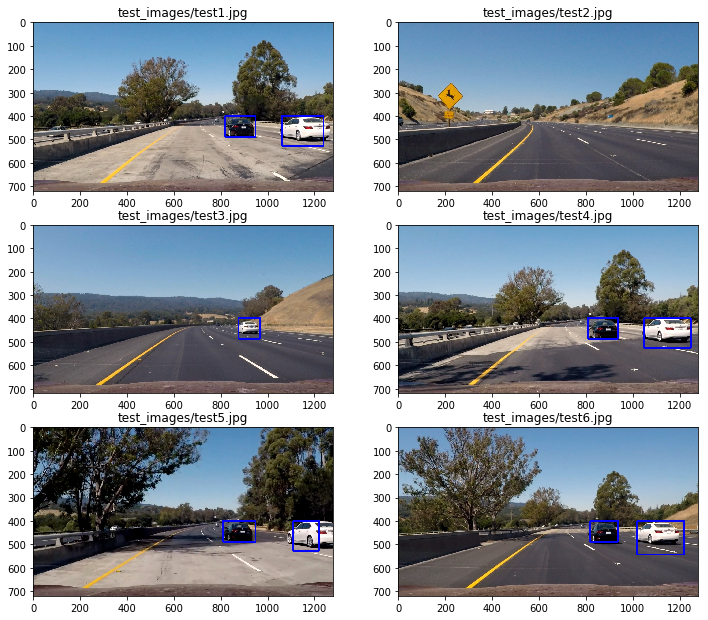

In [31]:
fig = plt.figure(figsize=(12,18))
idx=1
for img_src in glob.glob('test_images/*'):
        img = mpimg.imread(img_src)
        processed_img = process_single_image(img)
        
        plt.subplot(5,2,idx)
        plt.imshow(processed_img)
        plt.title(img_src)
        idx+=1
        

In [32]:
last_n = 5
heatmaps = [None] * last_n
iteration = 0

from functools import reduce

def pipeline(img):
    global iteration, last_n, heatmaps
    
    # parameters
    y_start_stops = [(400,475),(400,500),(400,500),(400, 650),(400,650)]
    x_start_stops = [(325, 950),(0,550),(700, 1280),(950, 1280),(0, 350)]
    scales = [.75, 1.25, 1.25, 2, 2]
    cells_per_steps = [2, 1, 1, 1, 1]
    
    heatmap = find_cars(img, y_start_stops, x_start_stops, scales, cells_per_steps)
    
    heatmaps[iteration % last_n] = heatmap
    if iteration >= last_n:
        integrated_heatmap = reduce(lambda x, y: x+y, heatmaps)
    else:
        integrated_heatmap = heatmap

    # threshold to minimize false positives
    apply_threshold(integrated_heatmap, threshold=25)
    
    # handy function as mentioned to generate labels from contiguous regions in heatmap
    labels = label(heatmap)
    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    iteration += 1
    
    return draw_img

In [ ]:
last_n = 5
heatmaps = [None] * last_n
iteration = 0

output_v1 = 'test_video_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
test_clip = clip1.fl_image(pipeline)

%time test_clip.write_videofile(output_v1, audio=False)

HTML("""
<video width="800" height="600" controls>
  <source src="{0}">
</video>
""".format(output_v1))

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 18%|█▊        | 7/39 [00:03<00:18,  1.76it/s]

In [ ]:
last_n = 5
heatmaps = [None] * last_n
iteration = 0

output_v1 = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
test_clip = clip1.fl_image(pipeline)

%time test_clip.write_videofile(output_v1, audio=False)

HTML("""
<video width="800" height="600" controls>
  <source src="{0}">
</video>
""".format(output_v1))